In [244]:
import pandas as pd
import numpy as np
import os


import seaborn as sns
import matplotlib.pyplot as plt

In [245]:
main_datasets = ["BACE_class", "BACE_regre", "ROR_class", "ROR_regre"]
top5 = {}

best_models = {}
best_models_avg_top = pd.DataFrame(columns=["dataset", "model", "split", "avg_top_score"])
best_models_preproessing_avg_top = pd.DataFrame(columns=["dataset", "model", "split", "avg_top_score"])
avg_top_count = 5
best_models_split = {}
hyperparameter_rank = {}
top_models_evaluated = 25

In [246]:
for dataset in main_datasets:
    df = pd.read_csv(r"Merged runs/" + dataset + ".csv")
    #print(df.columns)

    regre = False
    score_column = "roc_auc"
    if dataset[-5:] == "regre": 
        regre = True
        score_column = "mse"

    df.sort_values(score_column, ascending=regre, inplace=True)

    top5[dataset] = df.head(5)

    for model in df['model'].unique():
        right_model = df[df['model'] == model]

        for split in df['split'].unique():
            best_configs = right_model[df['split'] == split].head(top_models_evaluated)
            best_configs_hyperparams = best_configs[['hyperparams']]
            ### Avg top scores per model
            avg_top = best_configs.head(avg_top_count).loc[:, score_column].mean()
            best_models_avg_top.loc[len(best_models_avg_top.index)] = [dataset, model, split, avg_top]

            ### Top parameters frequency
            if not model in hyperparameter_rank.keys():
                hyperparameter_rank[model] = {}
            
            for index, row in best_configs_hyperparams.iterrows():
                params = list(row)[0][1:-1].split(", ")
                for param in params:
                    if not param in hyperparameter_rank[model].keys():
                        hyperparameter_rank[model][param] = 1
                    else:
                        hyperparameter_rank[model][param] += 1

    best_models_avg_top.sort_values(['dataset', 'model', 'split'], inplace=True)


    ### For each model, get 5 best configurations
        ### each parameter value from the configuration gets +1 in representation dict
        ### like {'LogisticRegression': {'solver: liblinear': x+1}}
    
    ### Separate on bace and ROR?


    best = {}
    for index, row in df.iterrows():
        if len(best) >= 7:
            break
        if not row['model'] in best.keys():
            best[row['model']] = [row[score_column], row['hyperparams']]

    best_models[dataset] = best
    
    df_temp = df.drop_duplicates(subset=['model', 'split'])

    df_temp.sort_values(['model', 'split'], inplace=True)

    df_temp = df_temp[['model', 'split', score_column]]

    best_models_split[dataset] = df_temp

C:\Users\wojci\AppData\Local\Temp\ipykernel_18896\4097935642.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_configs = right_model[df['split'] == split].head(top_models_evaluated)
C:\Users\wojci\AppData\Local\Temp\ipykernel_18896\4097935642.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_configs = right_model[df['split'] == split].head(top_models_evaluated)
C:\Users\wojci\AppData\Local\Temp\ipykernel_18896\4097935642.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_configs = right_model[df['split'] == split].head(top_models_evaluated)
C:\Users\wojci\AppData\Local\Temp\ipykernel_18896\4097935642.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_configs = right_model[df['split'] == split].head(top_models_evaluated)
C:\Users\wojci\AppData\Local\Temp\ipykernel_18896\4097935642.py:19: UserWarning: Boolean Series key will be rein

### Top 5 scores on a dataset

In [247]:
top5[main_datasets[0]]

,model,hyperparams,roc_auc,train_roc_auc,accuracy,train_accuracy,precision,train_precision,recall,train_recall,f1,train_f1,split,preprocessing
0,SVC,"{'C': 0.01, 'kernel': 'poly', 'gamma': 0.05}",0.880874,0.873432,0.881579,0.872153,0.887324,0.832268,0.863014,0.883051,0.875000,0.856908,0.9,Descriptors
1,MLPClassifier,"{'hidden_layer_sizes': (50, 50), 'activation':...",0.876626,0.950669,0.875000,0.946363,0.837500,0.902022,0.917808,0.983051,0.875817,0.940795,0.9,DescFing
2,LogisticRegression,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.874025,0.920109,0.875000,0.919177,0.885714,0.890879,0.849315,0.927119,0.867133,0.908638,0.9,DescFing
3,MLPClassifier,"{'hidden_layer_sizes': (100,), 'activation': '...",0.869256,0.889231,0.868421,0.884644,0.844156,0.829528,0.890411,0.923729,0.866667,0.874098,0.9,Descriptors
4,MLPClassifier,"{'hidden_layer_sizes': (100,), 'activation': '...",0.867696,0.961201,0.868421,0.960323,0.873239,0.942244,0.849315,0.967797,0.861111,0.954849,0.9,Fingerprints


### Best performance of each model on the dataset

In [248]:
best_models[main_datasets[0]]

{'SVC': [0.8808739379226634, "{'C': 0.01, 'kernel': 'poly', 'gamma': 0.05}"],
 'MLPClassifier': [0.8766256285763829,
  "{'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'alpha': 0.01, 'max_iter': 500, 'solver': 'sgd'}"],
 'LogisticRegression': [0.8740246228541703,
  "{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}"],
 'GradientBoostingClassifier': [0.8671753077856772,
  "{'max_depth': 3, 'loss': 'exponential', 'n_estimators': 200, 'learning_rate': 1.0, 'min_impurity_decrease': 0.05}"],
 'RandomForestClassifier': [0.8613663950060689,
  "{'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0, 'n_estimators': 200}"],
 'XGBClassifier': [0.8555574822264608,
  "{'max_depth': 7, 'eta': 0.1, 'gamma': 0}"],
 'DecisionTreeClassifier': [0.8374097834803528,
  "{'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0, 'criterion': 'log_loss', 'splitter': 'best'}"]}

In [249]:
best_models[main_datasets[2]]

{'GradientBoostingClassifier': [0.8000508130081301,
  "{'max_depth': 7, 'loss': 'exponential', 'n_estimators': 100, 'learning_rate': 1.0, 'min_impurity_decrease': 0.1}"],
 'MLPClassifier': [0.7848069105691057,
  "{'hidden_layer_sizes': (50, 50), 'activation': 'tanh', 'alpha': 0.01, 'max_iter': 1000, 'solver': 'sgd'}"],
 'XGBClassifier': [0.7780741869918699,
  "{'max_depth': 5, 'eta': 0.1, 'gamma': 0}"],
 'RandomForestClassifier': [0.7572408536585366,
  "{'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4, 'min_impurity_decrease': 0, 'n_estimators': 10}"],
 'SVC': [0.7566056910569106, "{'C': 1, 'kernel': 'poly', 'gamma': 0.1}"],
 'LogisticRegression': [0.7486026422764227,
  "{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}"],
 'DecisionTreeClassifier': [0.7484756097560976,
  "{'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'min_impurity_decrease': 0, 'criterion': 'gini', 'splitter': 'best'}"]}

In [250]:
best_models[main_datasets[1]]

{'SVR': [0.3864183150131471,
  "{'C': 1, 'kernel': 'rbf', 'epsilon': 0.01, 'gamma': 'scale'}"],
 'MLPRegressor': [0.4207656337225368,
  "{'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 0.01, 'max_iter': 1000, 'solver': 'sgd'}"],
 'XGBRegressor': [0.4328183095221637,
  "{'max_depth': 3, 'eta': 0.2, 'gamma': 0}"],
 'GradientBoostingRegressor': [0.4423980411011112,
  "{'max_depth': 3, 'loss': 'squared_error', 'n_estimators': 100, 'learning_rate': 0.1, 'min_impurity_decrease': 0.1}"],
 'RandomForestRegressor': [0.4886696185113259,
  "{'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0, 'n_estimators': 100}"],
 'DecisionTreeRegressor': [0.5852374568905848,
  "{'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 0, 'splitter': 'random', 'criterion': 'poisson'}"],
 'LinearRegression': [1.073240982224002, '{}']}

In [251]:
best_models[main_datasets[3]]

{'RandomForestRegressor': [0.4133075157442419,
  "{'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'min_impurity_decrease': 0, 'n_estimators': 10}"],
 'SVR': [0.4144492845381169,
  "{'C': 0.01, 'kernel': 'poly', 'epsilon': 0.1, 'gamma': 0.1}"],
 'GradientBoostingRegressor': [0.4212527721113082,
  "{'max_depth': 7, 'loss': 'huber', 'n_estimators': 100, 'learning_rate': 0.1, 'min_impurity_decrease': 0.2}"],
 'MLPRegressor': [0.439810552466729,
  "{'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 0.01, 'max_iter': 200, 'solver': 'sgd'}"],
 'XGBRegressor': [0.4441052077530608,
  "{'max_depth': None, 'eta': 0.1, 'gamma': 0}"],
 'DecisionTreeRegressor': [0.5566470912087783,
  "{'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 0, 'splitter': 'random', 'criterion': 'absolute_error'}"],
 'LinearRegression': [8.196392097841139, '{}']}

### Model performance on each split

In [252]:
best_models_split[main_datasets[1]]

,model,split,mse
36464,DecisionTreeRegressor,0.1,1.163881
31632,DecisionTreeRegressor,0.2,1.102910
25140,DecisionTreeRegressor,0.3,1.029016
20721,DecisionTreeRegressor,0.4,0.975412
16217,DecisionTreeRegressor,0.5,0.904284
...,...,...,...
3355,XGBRegressor,0.5,0.616946
1548,XGBRegressor,0.6,0.559181
1145,XGBRegressor,0.7,0.543746
166,XGBRegressor,0.8,0.479148


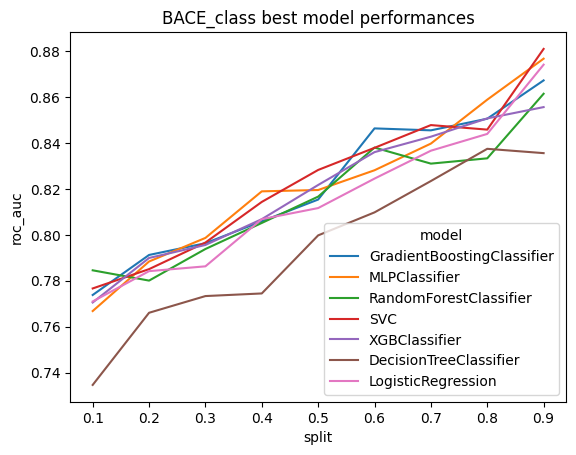

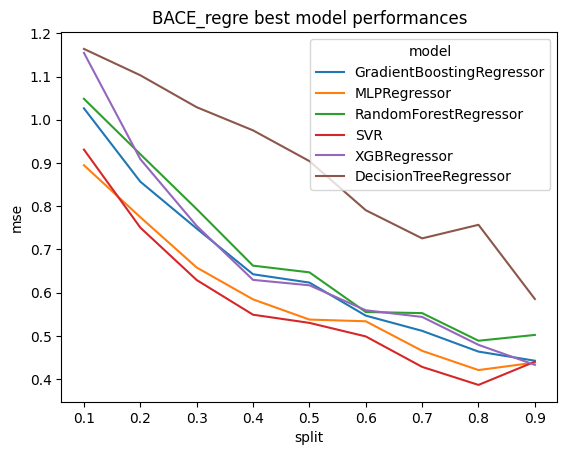

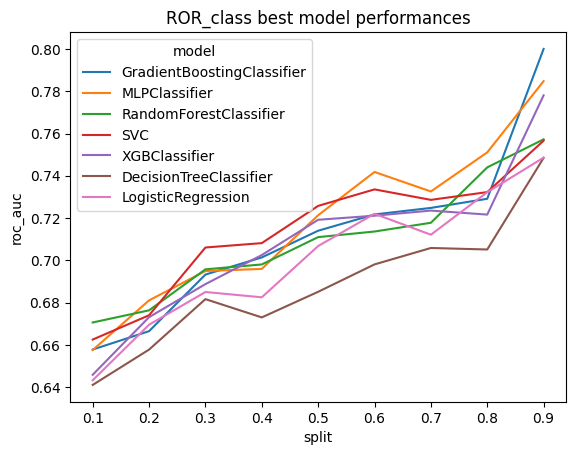

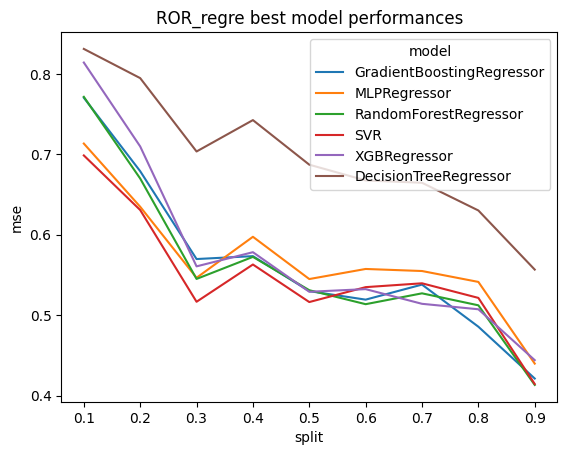

<Figure size 640x480 with 0 Axes>

In [253]:
for dataset_name in main_datasets:
    data = best_models_split[dataset_name]
    #mask = data[data.columns[2]] > 5
    mask = data['model'] == "LinearRegression"
    data = data[~mask]
    mask = data['model'] == "DecisionTreeClassifier"
    temp = data[mask]
    data = data[~mask]
    data = pd.concat([data, temp], ignore_index=True)
    mask = data['model'] == "DecisionTreeRegressor"
    temp = data[mask]
    data = data[~mask]
    data = pd.concat([data, temp], ignore_index=True)
    mask = data['model'] == "LogisticRegression"
    logistic = data[mask]
    data = data[~mask]
    data = pd.concat([data, logistic], ignore_index=True)
    sns.lineplot(data=data, x="split", y=data.columns[2], hue="model").set(title=dataset_name + " best model performances")
    plt.savefig(r"C:\Users\wojci\Documents\GitHub\czasteczkowa-inzynierka\experiments\plots\\" + dataset_name + ".png")
    plt.figure()

### Model comparison with average score of 5 best models

In [254]:
best_models_avg_top

,dataset,model,split,avg_top_score
62,BACE_class,DecisionTreeClassifier,0.1,0.724285
61,BACE_class,DecisionTreeClassifier,0.2,0.763446
60,BACE_class,DecisionTreeClassifier,0.3,0.763775
59,BACE_class,DecisionTreeClassifier,0.4,0.769575
58,BACE_class,DecisionTreeClassifier,0.5,0.796878
...,...,...,...,...
229,ROR_regre,XGBRegressor,0.5,0.537826
227,ROR_regre,XGBRegressor,0.6,0.541603
228,ROR_regre,XGBRegressor,0.7,0.523398
226,ROR_regre,XGBRegressor,0.8,0.517833


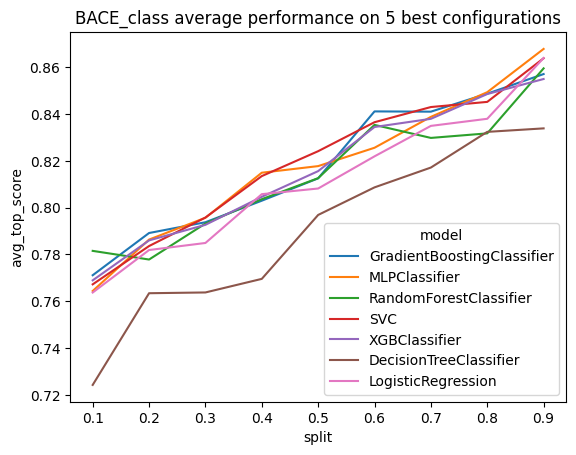

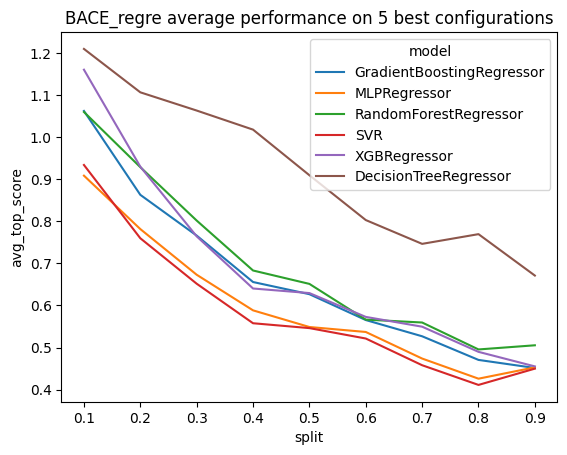

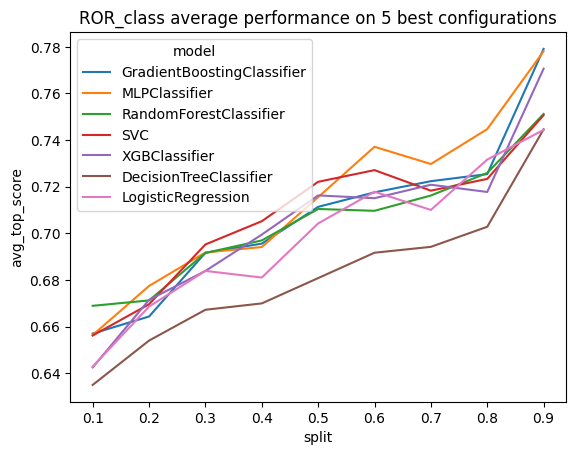

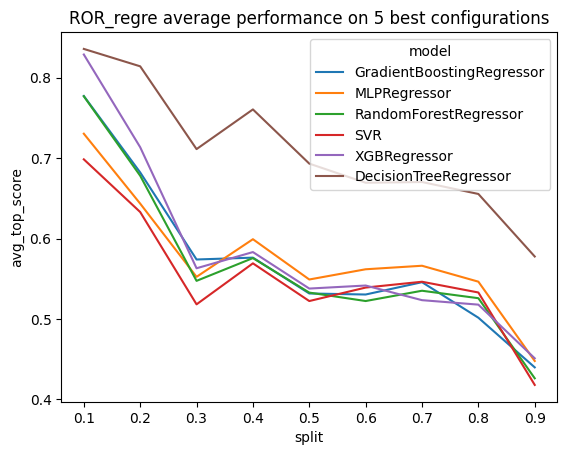

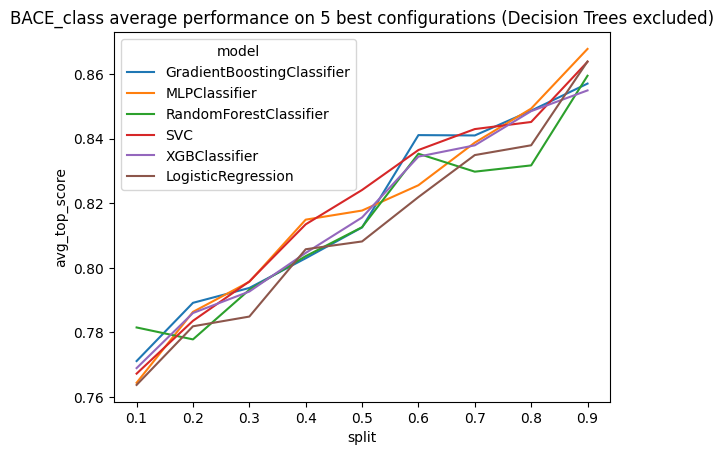

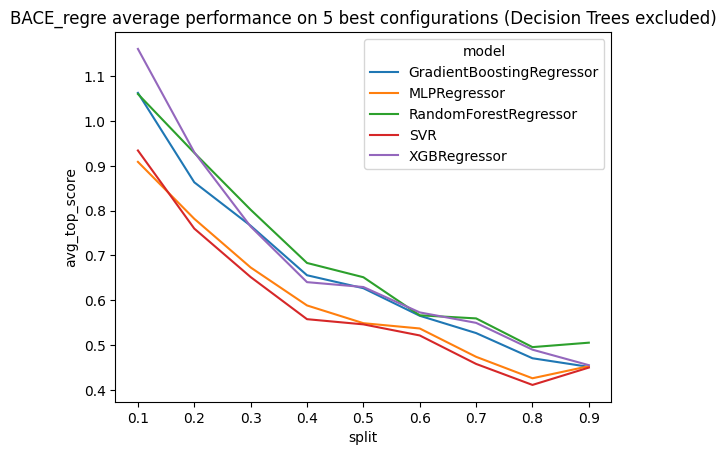

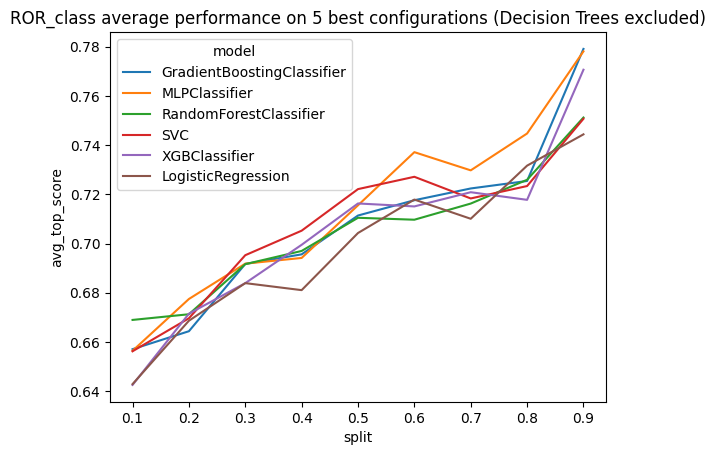

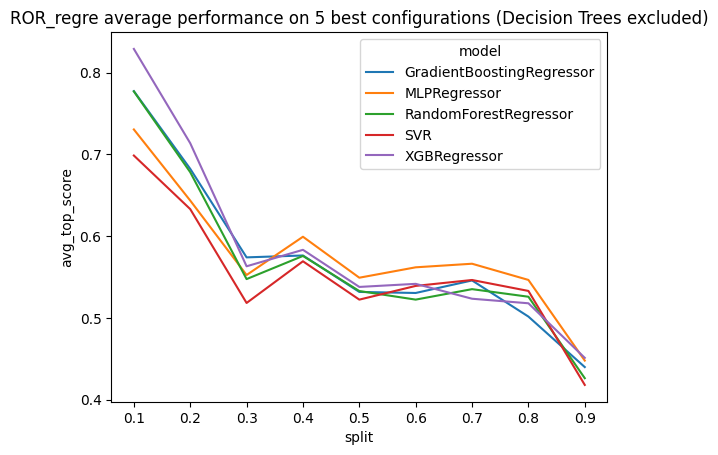

<Figure size 640x480 with 0 Axes>

In [255]:
for dataset_name in main_datasets:
    data = best_models_avg_top[best_models_avg_top["dataset"] == dataset_name]
    #mask = data[data.columns[2]] > 5
    mask = data['model'] == "LinearRegression"
    data = data[~mask]
    mask = data['model'] == "DecisionTreeClassifier"
    temp = data[mask]
    data = data[~mask]
    data = pd.concat([data, temp], ignore_index=True)
    mask = data['model'] == "DecisionTreeRegressor"
    temp = data[mask]
    data = data[~mask]
    data = pd.concat([data, temp], ignore_index=True)
    mask = data['model'] == "LogisticRegression"
    logistic = data[mask]
    data = data[~mask]
    data = pd.concat([data, logistic], ignore_index=True)
    sns.lineplot(data=data, x="split", y=data.columns[3], hue="model").set(title=dataset_name + " average performance on " + str(avg_top_count) + " best configurations")
    plt.savefig(r"C:\Users\wojci\Documents\GitHub\czasteczkowa-inzynierka\experiments\plots\\" + dataset_name + "_avg_top_" + str(avg_top_count) + ".png")
    plt.figure()

for dataset_name in main_datasets:
    data = best_models_avg_top[best_models_avg_top["dataset"] == dataset_name]
    #mask = data[data.columns[2]] > 5
    mask = data['model'] == "LinearRegression"
    data = data[~mask]
    mask = data['model'] == "DecisionTreeClassifier"
    data = data[~mask]
    mask = data['model'] == "DecisionTreeRegressor"
    data = data[~mask]
    mask = data['model'] == "LogisticRegression"
    logistic = data[mask]
    data = data[~mask]
    data = pd.concat([data, logistic], ignore_index=True)
    sns.lineplot(data=data, x="split", y=data.columns[3], hue="model").set(title=dataset_name + " average performance on " + str(avg_top_count) + " best configurations (Decision Trees excluded)")
    plt.savefig(r"C:\Users\wojci\Documents\GitHub\czasteczkowa-inzynierka\experiments\plots\\" + dataset_name + "_avg_top_" + str(avg_top_count) + "_treeless.png")
    plt.figure()

### Hyperparameter importance (how ofted do they appear in top 5 configurations)

In [256]:
for mlp in ['MLPClassifier', 'MLPRegressor']:

    hyperparameter_rank[mlp]["'hidden_layer_sizes': (50, 50)"] = hyperparameter_rank[mlp]["'hidden_layer_sizes': (50"]
    hyperparameter_rank[mlp].pop("'hidden_layer_sizes': (50")
    hyperparameter_rank[mlp].pop("50)")


for key, items in hyperparameter_rank.items():
    hyperparameter_rank[key] = sorted(items.items(), key=lambda x: x[1], reverse=True)

hyperparameter_rank

{'SVC': [("'kernel': 'poly'", 226),
  ("'gamma': 0.05", 180),
  ("'kernel': 'rbf'", 158),
  ("'gamma': 'scale'", 157),
  ("'C': 10", 113),
  ("'gamma': 0.1", 113),
  ("'C': 100", 83),
  ("'C': 1000", 76),
  ("'C': 0.1", 75),
  ("'kernel': 'linear'", 62),
  ("'C': 1", 60),
  ("'C': 0.01", 43),
  ("'kernel': 'sigmoid'", 4)],
 'MLPClassifier': [("'solver': 'sgd'", 268),
  ("'activation': 'relu'", 229),
  ("'max_iter': 500", 180),
  ("'max_iter': 1000", 168),
  ("'alpha': 0.001", 158),
  ("'hidden_layer_sizes': (50, 50)", 156),
  ("'alpha': 0.01", 154),
  ("'activation': 'tanh'", 154),
  ("'hidden_layer_sizes': (50,)", 149),
  ("'hidden_layer_sizes': (100,)", 145),
  ("'alpha': 0.0001", 138),
  ("'solver': 'adam'", 109),
  ("'max_iter': 200", 102),
  ("'solver': 'lbfgs'", 73),
  ("'activation': 'logistic'", 67)],
 'LogisticRegression': [("'penalty': 'l2'", 283),
  ("'solver': 'saga'", 256),
  ("'solver': 'liblinear'", 187),
  ("'penalty': 'l1'", 160),
  ("'C': 1", 148),
  ("'C': 10", 119),

In [257]:
parameter_df = pd.DataFrame(columns=["model", "parameter", "frequency"])
for model, parameters in hyperparameter_rank.items():
    for parameter in parameters:
        parameter_df.loc[len(parameter_df.index)] = [model, parameter[0], parameter[1]]

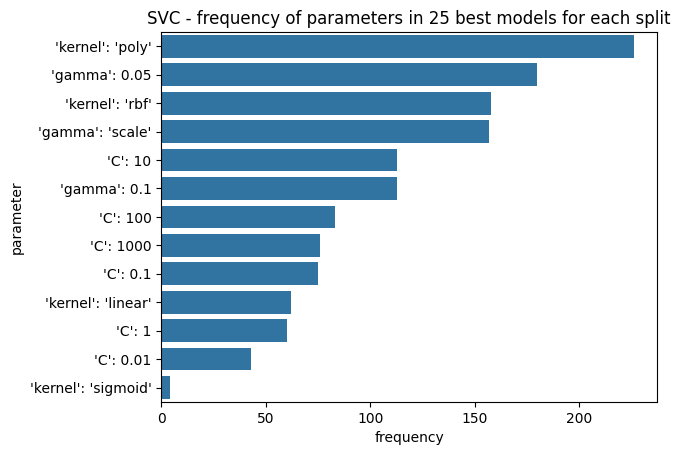

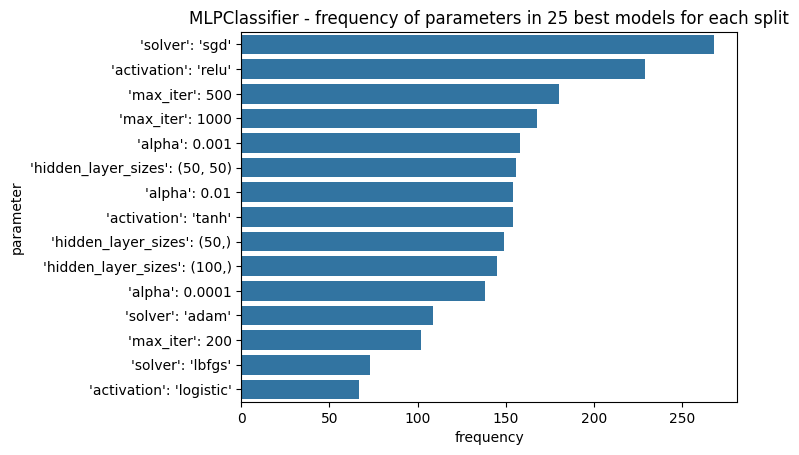

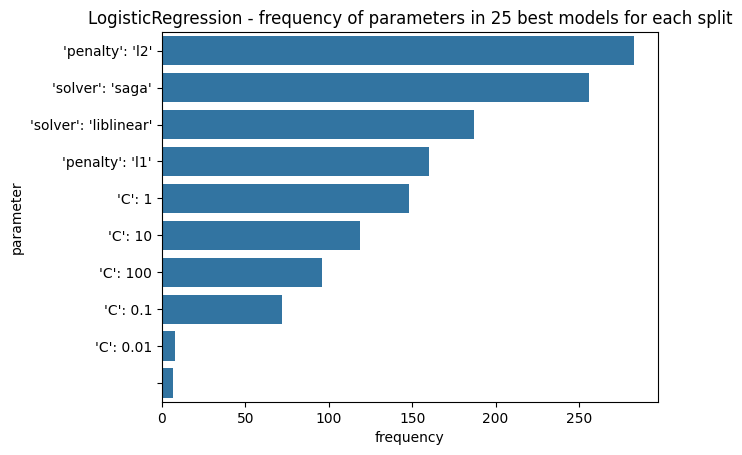

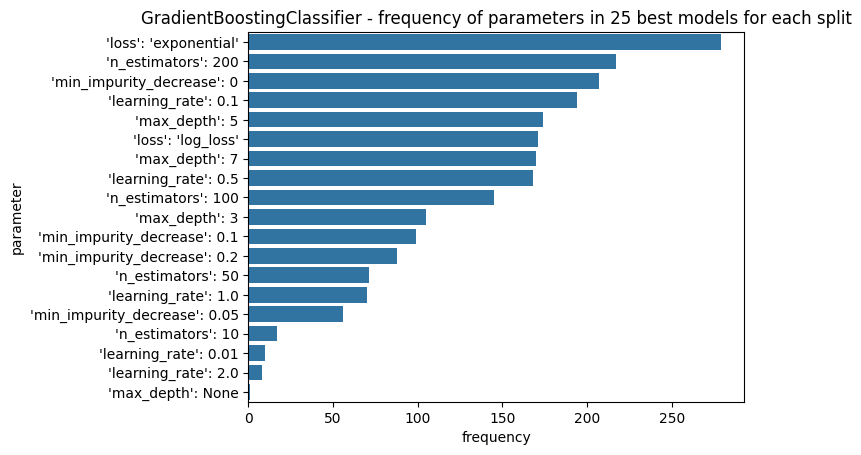

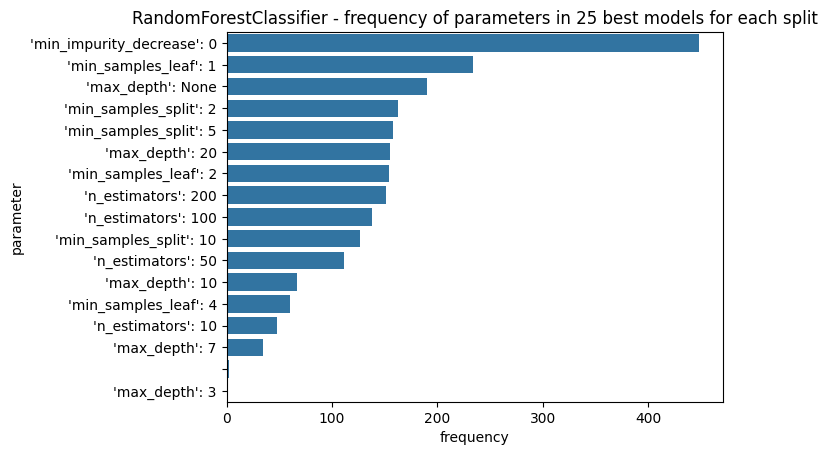

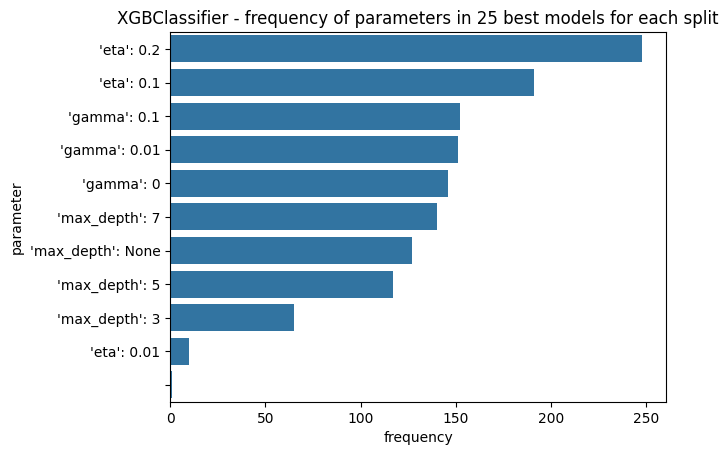

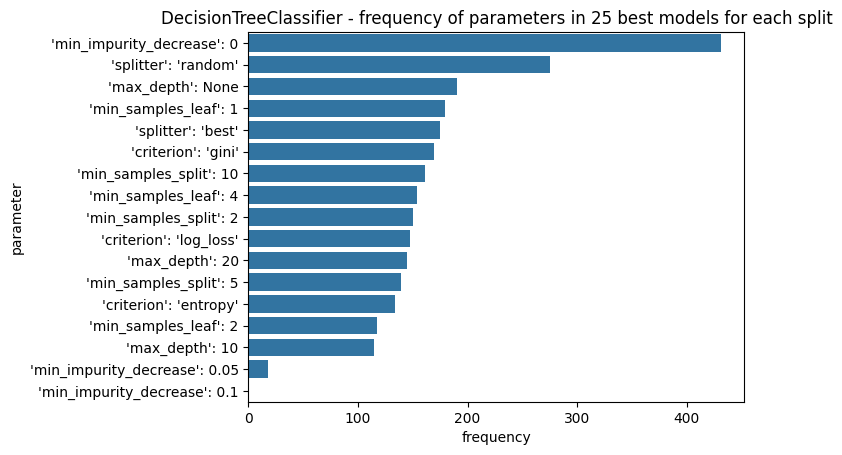

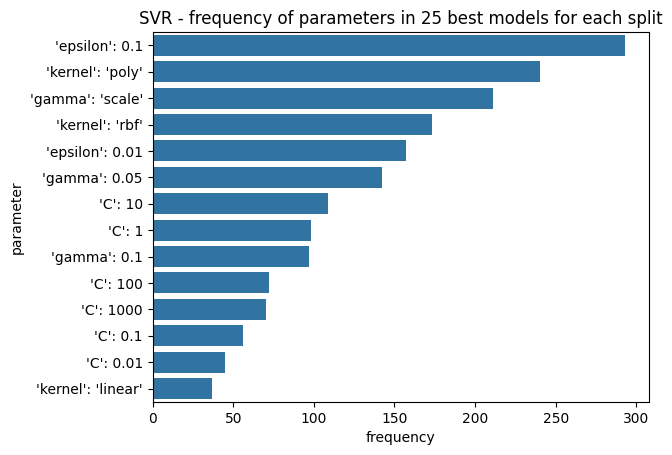

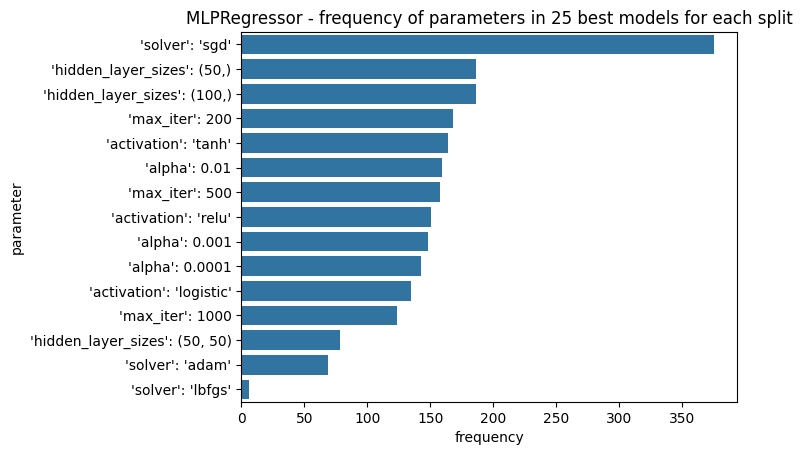

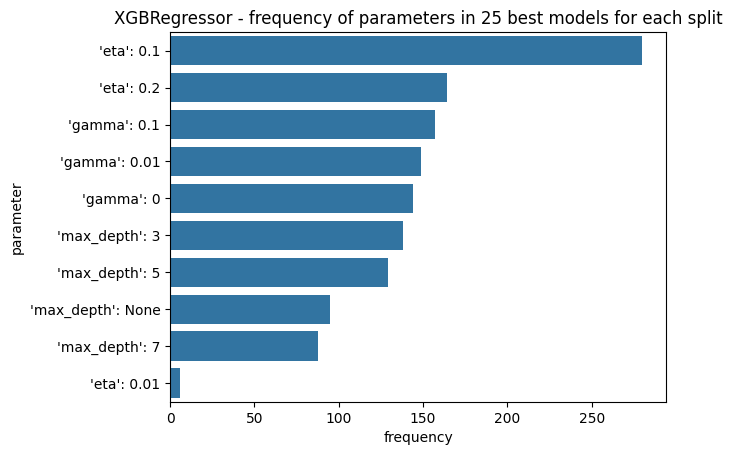

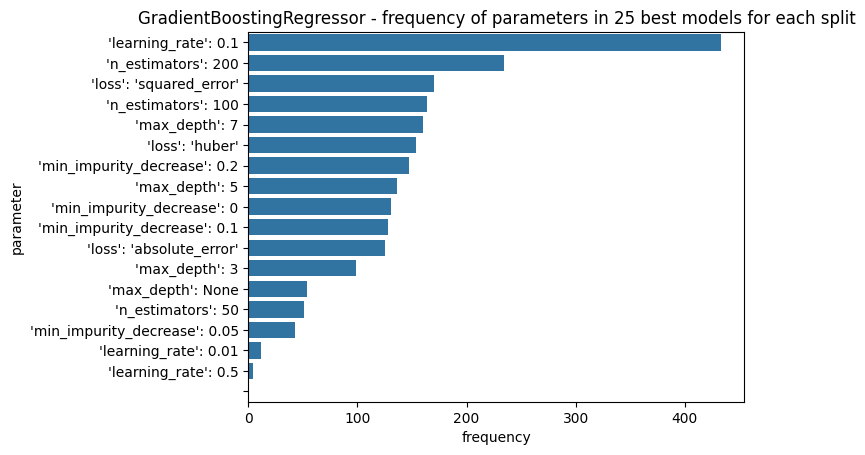

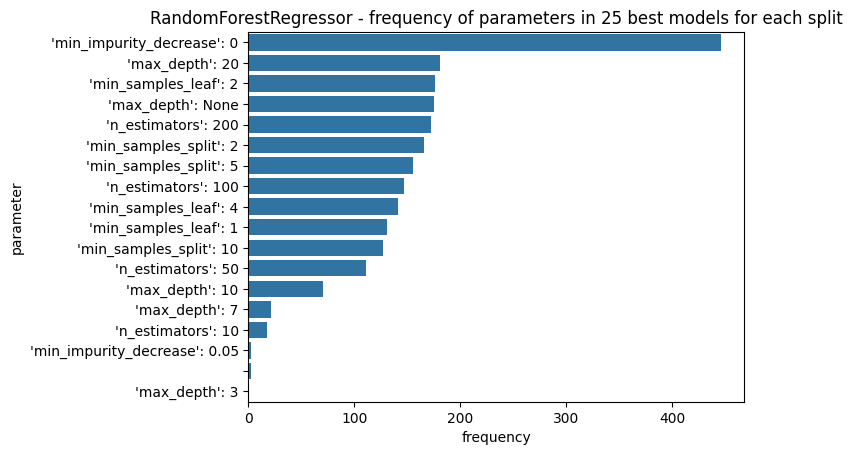

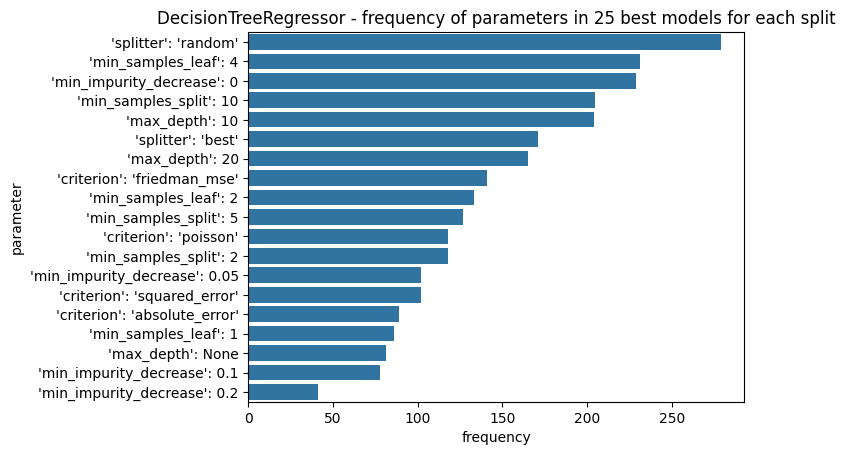

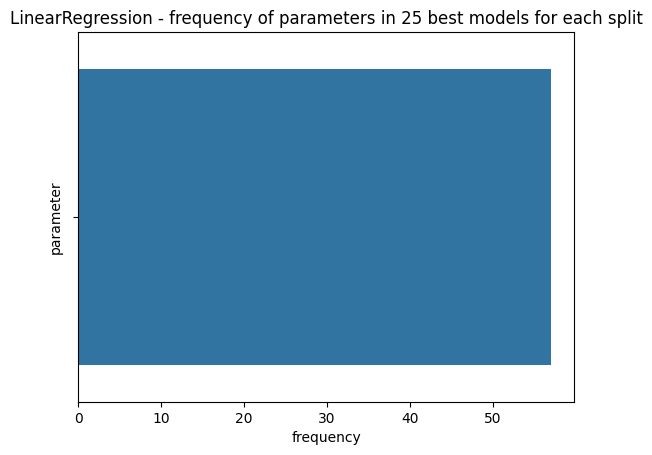

<Figure size 640x480 with 0 Axes>

In [258]:
for model in parameter_df['model'].unique():
    mask = parameter_df['model'] == model
    data = parameter_df[mask]

    sns.barplot(data=data, y="parameter", x="frequency", orient="h").set(title=model + " - frequency of parameters in " + str(top_models_evaluated) + " best models for each split")
    #plt.xticks(rotation=90)
    plt.savefig(r"C:\Users\wojci\Documents\GitHub\czasteczkowa-inzynierka\experiments\plots\\param_freq_" + model + ".png")
    plt.figure()

### 